Project 3 - Portfolio Optimization and Risk Management

This project explores how to build and evaluate a stock portfolio. We begin by downloading historical price data and converting it into log returns, which form the basis for estimating expected returns and risk. Using the Markowitz mean–variance framework, we calculate portfolio return and volatility and then apply optimization techniques to find the allocation that maximizes the Sharpe ratio. The efficient frontier is plotted to show the trade-off between risk and return. We then extend the analysis by estimating Value-at-Risk (VaR) and Expected Shortfall (ES), both through historical data and Monte Carlo simulations, before validating the results with a statistical backtest. The overall goal is to understand how quantitative methods can guide investment decisions and measure the robustness of risk models.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from scipy.optimize import minimize

# risk-free rate (annual).
r_f = 0.0

tickers = ["AAPL","MSFT","AMZN","JPM","XOM","TSLA"]
start = "2022-01-01"
end = "2024-12-31"

data = yf.download(tickers, start=start, end=end)
df = data['Close']          # just the closing prices
df = df.dropna()            # clean missing values

returns = np.log(df / df.shift(1)).dropna()
trading_days = 252

# annualised mean and vol
mean_daily = returns.mean()
cov_daily = returns.cov()

mu_annual = mean_daily * trading_days
cov_annual = cov_daily * trading_days
vol_annual = np.sqrt(np.diag(cov_annual))

C:\Users\Jacon\AppData\Local\Temp\ipykernel_1508\3049409195.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  6 of 6 completed


# Data Collection and Preprocessing

This section mirrors the workflow from **Project 2**, where we downloaded historical stock price data, converted it into log returns, and computed daily statistics such as mean and covariance. The same process is followed here to annualize returns and volatilities, providing the inputs needed for portfolio optimization and risk analysis.

In [6]:
n = len(tickers)
w_eq = np.array([1.0/n]*n)          # equal weights
mu = mu_annual.values               # vector of annual returns
cov = cov_annual.values             # annual covariance matrix

# helper functions: mu_p = w^T.mu sigma_p = sqrt(w^T.covmat(w))
def port_return(w, mu_vec):
    """Annual expected portfolio return given weights and mu vector"""
    return float(np.dot(w, mu_vec))

def port_vol(w, cov_mat):
    """Annual portfolio volatility (std)"""
    return float(np.sqrt(np.dot(w.T, np.dot(cov_mat, w))))


# Portfolio Setup and Helper Functions

We begin by defining an **equal-weight portfolio**, where each of the $n$ assets is assigned the same weight $w_i = \tfrac{1}{n}$. In Python, this is stored as a NumPy array `w_eq`.

From earlier, we already have the **annualized mean returns** $\mu$ (a vector) and the **annualized covariance matrix** $\Sigma$ (a square matrix). These are extracted as NumPy arrays for computation.

Two helper functions are then defined:

- **`port_return(w, mu_vec)`**: Computes the expected annual portfolio return using  
  $$
  \mu_p = w^\top \mu
  $$
  implemented with `np.dot(w, mu_vec)`.

- **`port_vol(w, cov_mat)`**: Computes the annual portfolio volatility (standard deviation of returns) using  
  $$
  \sigma_p = \sqrt{w^\top \Sigma w}
  $$
  implemented with `np.dot` twice inside a square root.

These functions let us evaluate any portfolio’s expected return and risk, given weights $w$.


In [7]:
ret_eq = port_return(w_eq, mu)
vol_eq = port_vol(w_eq, cov)
sharpe_sh = (ret_eq - r_f) / vol_eq
print("Equal weight portfolio")
print("Weights:", dict(zip(tickers, np.round(w_eq,3))))
print(f"Expected return (annual): {ret_eq:.2%}")
print(f"Volatility (annual): {vol_eq:.2%}")
print(f" Sharpe: {sharpe_sh:.3f}")


Equal weight portfolio
Weights: {'AAPL': 0.167, 'MSFT': 0.167, 'AMZN': 0.167, 'JPM': 0.167, 'XOM': 0.167, 'TSLA': 0.167}
Expected return (annual): 11.20%
Volatility (annual): 23.96%
 Sharpe: 0.467


# Equal-Weight Portfolio Evaluation

Using the helper functions, we first calculate the **expected annual return** and **volatility** of the equal-weight portfolio:

- Portfolio return:
  $$
  \mu_p = w^\top \mu
  $$

- Portfolio volatility:
  $$
  \sigma_p = \sqrt{w^\top \Sigma w}
  $$

The **Sharpe ratio** is then computed as:
$$
\text{Sharpe} = \frac{\mu_p - r_f}{\sigma_p}
$$
where $r_f$ is the risk-free rate (set to 0 here).  

In Python:
- `ret_eq = port_return(w_eq, mu)` gives the expected return.  
- `vol_eq = port_vol(w_eq, cov)` gives the volatility.  
- `sharpe_sh = (ret_eq - r_f) / vol_eq` computes the Sharpe ratio.  

Finally, the results are printed: portfolio weights, expected return, volatility, and Sharpe ratio. This establishes the **baseline performance** of an equal-weight portfolio.

In [8]:
def neg_sharpe(w, mu_vec, cov_mat, rf=r_f):
    ret = port_return(w, mu_vec)     # w^T * mu  (expected return)
    vol = port_vol(w, cov_mat)       # sqrt(w^T Σ w)  (volatility)
    if vol == 0:                     # avoid divide by zero
        return 1e6
    return - (ret - rf) / vol        # negative Sharpe

# Negative Sharpe Ratio Function

The purpose of this function is to provide an objective that can be passed into an optimizer in order to **maximize the Sharpe ratio of a portfolio**. Since Python’s `scipy.optimize.minimize` is designed to minimize a function, we return the *negative* of the Sharpe ratio. Minimizing this negative value is mathematically equivalent to maximizing the original ratio.

The function begins with the line `ret = port_return(w, mu_vec)`. Here, the input `w` is the weight vector of the portfolio, and `mu_vec` is the vector of expected returns for each asset. The helper function `port_return` computes the dot product $w^\top \mu$, which represents the expected return of the portfolio. This ensures that the optimizer evaluates the performance of a given set of weights in terms of expected reward.

Next, `vol = port_vol(w, cov_mat)` calculates the portfolio’s risk. The helper function `port_vol` applies the quadratic form $\sqrt{w^\top \Sigma w}$, where $\Sigma$ is the covariance matrix of asset returns. This gives the portfolio’s volatility, which is required for the denominator of the Sharpe ratio. In Python, the call leverages NumPy’s efficient array operations to perform this matrix multiplication under the hood.

The following conditional, `if vol == 0: return 1e6`, is a defensive programming step. In the unlikely event that the volatility is exactly zero, dividing by it would produce an error. Instead of crashing, the function returns a very large number (`1e6`), effectively penalizing this weight configuration and ensuring the optimizer discards it.

Finally, the line `return - (ret - rf) / vol` completes the function. The numerator is the excess return over the risk-free rate $r_f$, while the denominator is the portfolio volatility. This is the standard Sharpe ratio, but with a negative sign attached. The purpose of this inversion is so that minimizing this function with respect to $w$ is equivalent to maximizing the original Sharpe ratio. Thus, each line of code collectively transforms the optimization problem into one the solver can handle, linking the mathematical definition of the Sharpe ratio directly to a Python implementation that can be optimized.


In [9]:

cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) #weights must sum to 1 (fully invest)
bounds = tuple((0,1) for _ in range(n)) #no short selling (positive weight)
w0 = w_eq.copy() #start at equal

res = minimize(neg_sharpe, w0, args=(mu, cov),
               method='SLSQP', bounds=bounds, constraints=cons) # Sequential least squares programming (finds portfolio with lowest neg sharpe => highest sharpe)

w_sharpe = res.x
ret_sh = port_return(w_sharpe, mu)
vol_sh = port_vol(w_sharpe, cov)
sharpe_sh = (ret_sh - r_f) / vol_sh

print("Max-Sharpe portfolio (no shorting):")
print("Weights:", dict(zip(tickers, np.round(w_sharpe,3))))
print(f"Return: {ret_sh:.2%}, Vol: {vol_sh:.2%}, Sharpe: {sharpe_sh:.3f}")

Max-Sharpe portfolio (no shorting):
Weights: {'AAPL': 0.128, 'MSFT': 0.0, 'AMZN': 0.346, 'JPM': 0.031, 'XOM': 0.0, 'TSLA': 0.496}
Return: 17.50%, Vol: 19.66%, Sharpe: 0.890


# Maximum Sharpe Ratio Portfolio Optimization

This section of code uses numerical optimization to find the portfolio with the highest Sharpe ratio, subject to realistic constraints. This can now be easily done by minimising the Negative Sharpe Ratio.

The first line sets up a constraint dictionary, where `{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}` enforces that the portfolio weights must sum exactly to one, ensuring that the portfolio is fully invested. Next, `bounds = tuple((0,1) for _ in range(n))` restricts each asset’s weight to lie between 0 and 1, preventing short selling and leverage. The variable `w0 = w_eq.copy()` defines the starting point of the optimization which will be equal weight allocation. 

The optimization is then carried out with `minimize`, where the objective is the `neg_sharpe` function. The arguments `(mu, cov)` supply the expected returns and covariance matrix, and the method SLSQP (Sequential Least Squares Programming) is chosen because it naturally handles both equality constraints and box constraints. Under the hood, this algorithm iteratively adjusts the weights to search for the allocation that minimizes the negative Sharpe ratio, i.e. maximizes the Sharpe ratio.

Once the optimizer finds a solution, the optimal weights are stored in `w_sharpe = res.x`. These weights are then fed into the previously defined helper functions: `port_return(w_sharpe, mu)` computes the expected return, while `port_vol(w_sharpe, cov)` computes volatility. The Sharpe ratio is finally recomputed as `(ret_sh - r_f) / vol_sh` for clarity.

The print statements at the end display the optimized allocation alongside its risk–return profile. Conceptually, this procedure implements Markowitz’s mean–variance optimization, but specifically focused on finding the portfolio on the efficient frontier that maximizes the Sharpe ratio. In practical portfolio management, this is often referred to as the tangency portfolio.

In [10]:
r_min = min(mu)
r_max = max(mu)
target_returns = np.linspace(r_min, r_max, 40)

frontier_vols = []
frontier_weights = []

for r_target in target_returns:
    cons = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w, r_target=r_target: port_return(w, mu) - r_target}
    )
    res = minimize(lambda w: port_vol(w, cov), w0, method='SLSQP', bounds=bounds, constraints=cons)
    if not res.success:
        frontier_vols.append(np.nan)
        frontier_weights.append(None)
    else:
        frontier_vols.append(res.fun)
        frontier_weights.append(res.x)

### Efficient Frontier Construction

This section of the code implements the **Markowitz framework** by calculating the efficient frontier. The efficient frontier is the set of portfolios that minimize risk for a given target return, or equivalently maximize return for a given risk. It is the fundamental object of Modern Portfolio Theory.

We begin by setting the range of returns that the frontier will cover: `r_min = min(mu)` and `r_max = max(mu)` extract the minimum and maximum expected returns across all individual assets in the portfolio universe. These serve as the lower and upper bounds for the target portfolio returns. `target_returns = np.linspace(r_min, r_max, 40)` then generates 40 evenly spaced target return values between these bounds. Each of these will become a constraint in a separate optimization problem.

Two lists, `frontier_vols` and `frontier_weights`, are initialized as empty containers to store the optimal volatilities and corresponding weights for each target return.

The `for` loop iterates over every `r_target` in the `target_returns` array. For each target return, a set of constraints is defined:
1. `{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}` ensures that the portfolio is fully invested (the weights must sum to one).
2. `{'type': 'eq', 'fun': lambda w, r_target=r_target: port_return(w, mu) - r_target}` enforces that the chosen portfolio must achieve exactly the target return. Here, `port_return(w, mu)` computes $w^\top \mu$, the portfolio’s expected return, which is constrained to equal `r_target`.

The optimization is performed with `scipy.optimize.minimize`, where the objective is `lambda w: port_vol(w, cov)`. This function computes the portfolio volatility:
$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$
Thus, for each `r_target`, the algorithm searches for the portfolio weights $w$ that minimize volatility subject to the constraints. The method used is **SLSQP** (Sequential Least Squares Programming), which is well-suited to handle both equality constraints and box constraints such as bounds.

If the optimization fails (`res.success == False`), placeholders (`np.nan` and `None`) are appended to the lists. Otherwise, the optimizer’s results are stored: `res.fun` is the minimized volatility, and `res.x` is the vector of weights that achieved it.

After the loop completes, the two lists together define the efficient frontier: `frontier_vols` contains the minimum risks associated with each target return, and `frontier_weights` contains the corresponding optimal allocations.


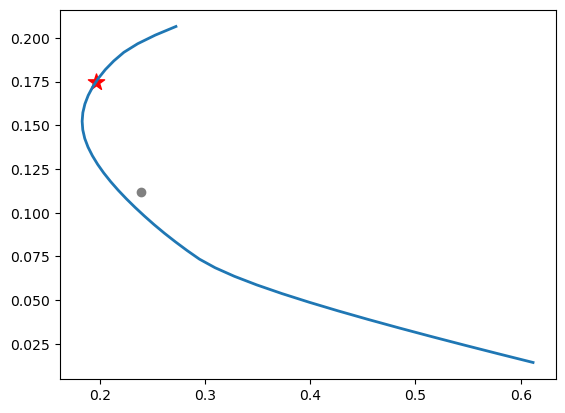

In [11]:
plt.plot(frontier_vols, target_returns, label='Efficient frontier', lw=2)
plt.scatter(vol_eq, ret_eq, c='gray', marker='o', label='Equal weight')
plt.scatter(vol_sh, ret_sh, c='red', marker='*', s=150, label='Max Sharpe')

### Plot Interpretation: Efficient Frontier

The plot illustrates the **efficient frontier** as the blue curve. The horizontal axis (x-axis) represents **portfolio volatility** (standard deviation of returns), which measures the total risk of the portfolio. Moving to the right along this axis indicates higher risk. The vertical axis (y-axis) represents the **expected portfolio return**, with higher values indicating greater anticipated performance.

Each point on the blue curve results from solving an optimization problem that minimizes risk for a given target return. In other words, the frontier shows the best possible trade-offs between risk and return available from the given assets. Any portfolio lying below the frontier is inefficient, because there exists another allocation that offers a higher return for the same or lower risk.

The gray circle denotes the **equal-weight portfolio**, where capital is evenly distributed across assets. Its placement below the frontier shows that while simple, this allocation is not optimal — higher returns could be achieved without increasing risk, or the same returns could be earned with less risk.

The red star marks the **maximum Sharpe ratio portfolio**, also called the **tangency portfolio**. It lies on the frontier at the point where risk-adjusted performance is maximized. This portfolio offers the steepest slope in terms of return per unit of risk, making it the most efficient allocation when the objective is to maximize performance relative to risk.

Taken together, the axes and the plot convey Markowitz’s fundamental insight: diversification shapes the curved frontier by reducing volatility relative to expected return, and rational investors should choose allocations along this frontier rather than below it.
